# **Emission de CO2 par les véhicules - Classification Modelisation DL**

## 0. Import des modules et sous modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api
import random
from scipy.stats import randint
from sklearn import metrics
import itertools

In [2]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures, label_binarize
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from sklearn.metrics import roc_curve, auc

from plotly.subplots import make_subplots
from sklearn import preprocessing

In [3]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier # regressor = DecisionTreeRegressor(random_state=0)
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, mean_squared_error, roc_curve, auc, roc_auc_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import os, sys

## 1. Import du DataSet et visualisation

In [5]:
data_final = pd.set_option('display.max_row', 111)
data_final = pd.set_option('display.max_column', 111)

In [6]:
data_final = pd.read_csv('df_final.csv')
df_final = data_final.copy()

In [7]:
df_final.head()

,Class_CO2,PuissanceMaximale_kW,masseVideEuroMax_kg,CO2_g_par_km,Marque_ALFA-ROMEO,Marque_ASTON MARTIN,Marque_AUDI,Marque_BENTLEY,Marque_BMW,Marque_CADILLAC,Marque_CHEVROLET,Marque_CITROEN,Marque_DACIA,Marque_DANGEL,Marque_FERRARI,Marque_FIAT,Marque_FORD,Marque_HONDA,Marque_HYUNDAI,Marque_INFINITI,Marque_JAGUAR,Marque_JAGUAR LAND ROVER LIMITED,Marque_JEEP,Marque_KIA,Marque_LADA,Marque_LAMBORGHINI,Marque_LANCIA,Marque_LAND ROVER,Marque_LEXUS,Marque_LOTUS,Marque_MASERATI,Marque_MAYBACH,Marque_MAZDA,Marque_MERCEDES,Marque_MERCEDES AMG,Marque_MERCEDES-BENZ,Marque_MINI,Marque_MITSUBISHI,Marque_NISSAN,Marque_OPEL,Marque_PEUGEOT,Marque_PORSCHE,Marque_QUATTRO,Marque_RENAULT,Marque_RENAULT TECH,Marque_ROLLS-ROYCE,Marque_SEAT,Marque_SKODA,Marque_SMART,Marque_SSANGYONG,Marque_SUBARU,Marque_SUZUKI,Marque_TOYOTA,Marque_VOLKSWAGEN,Marque_VOLVO,Carburant_C_autre,Carburant_ES,Carburant_GO,Hybride_non,Hybride_oui,BoîteDeVitesse_Auto,BoîteDeVitesse_BV_autre,BoîteDeVitesse_M,Carrosserie_BERLINE,Carrosserie_BREAK,Carrosserie_CABRIOLET,Carrosserie_COMBISPACE,Carrosserie_COUPE,Carrosserie_MINIBUS,Carrosserie_MINISPACE,Carrosserie_MONOSPACE,Carrosserie_MONOSPACE COMPACT,Carrosserie_TS TERRAINS/CHEMINS,gamme_ECONOMIQUE,gamme_INFERIEURE,gamme_LUXE,gamme_MOY-INF,gamme_MOY-SUPER,gamme_SUPERIEURE
0,E,0.544329,-1.809856,182.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,C,0.071365,-1.667545,136.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,C,-0.466095,-1.667545,134.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,C,-0.466095,-1.667545,134.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,C,0.071365,-1.667545,139.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [8]:
df_final = df_final.drop('CO2_g_par_km', axis = 1) # suppression de la variable cible "Class_CO2" destinée à la classification

In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98454 entries, 0 to 98453
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Class_CO2                         98454 non-null  object 
 1   PuissanceMaximale_kW              98454 non-null  float64
 2   masseVideEuroMax_kg               98454 non-null  float64
 3   Marque_ALFA-ROMEO                 98454 non-null  bool   
 4   Marque_ASTON MARTIN               98454 non-null  bool   
 5   Marque_AUDI                       98454 non-null  bool   
 6   Marque_BENTLEY                    98454 non-null  bool   
 7   Marque_BMW                        98454 non-null  bool   
 8   Marque_CADILLAC                   98454 non-null  bool   
 9   Marque_CHEVROLET                  98454 non-null  bool   
 10  Marque_CITROEN                    98454 non-null  bool   
 11  Marque_DACIA                      98454 non-null  bool   
 12  Marq

## 2. Encodage et mise en forme du dataset

### 2.1 Decoupage du dataset

In [13]:
# variables cible
df_cible = df_final["Class_CO2"]
# Variables explicative
df_explicative = df_final.drop("Class_CO2", axis = 1)

### 2.2 Encodage de la variable cible

In [15]:
encoder = LabelEncoder()
df_cible = encoder.fit_transform(df_cible)
classes=encoder.classes_

### 2.3 Concatenation

In [18]:
df_final = pd.concat([pd.DataFrame(df_cible, columns=["Class_CO2"]), df_explicative], axis = 1)
df_final.head(10)

,Class_CO2,PuissanceMaximale_kW,masseVideEuroMax_kg,Marque_ALFA-ROMEO,Marque_ASTON MARTIN,Marque_AUDI,Marque_BENTLEY,Marque_BMW,Marque_CADILLAC,Marque_CHEVROLET,Marque_CITROEN,Marque_DACIA,Marque_DANGEL,Marque_FERRARI,Marque_FIAT,Marque_FORD,Marque_HONDA,Marque_HYUNDAI,Marque_INFINITI,Marque_JAGUAR,Marque_JAGUAR LAND ROVER LIMITED,Marque_JEEP,Marque_KIA,Marque_LADA,Marque_LAMBORGHINI,Marque_LANCIA,Marque_LAND ROVER,Marque_LEXUS,Marque_LOTUS,Marque_MASERATI,Marque_MAYBACH,Marque_MAZDA,Marque_MERCEDES,Marque_MERCEDES AMG,Marque_MERCEDES-BENZ,Marque_MINI,Marque_MITSUBISHI,Marque_NISSAN,Marque_OPEL,Marque_PEUGEOT,Marque_PORSCHE,Marque_QUATTRO,Marque_RENAULT,Marque_RENAULT TECH,Marque_ROLLS-ROYCE,Marque_SEAT,Marque_SKODA,Marque_SMART,Marque_SSANGYONG,Marque_SUBARU,Marque_SUZUKI,Marque_TOYOTA,Marque_VOLKSWAGEN,Marque_VOLVO,Carburant_C_autre,Carburant_ES,Carburant_GO,Hybride_non,Hybride_oui,BoîteDeVitesse_Auto,BoîteDeVitesse_BV_autre,BoîteDeVitesse_M,Carrosserie_BERLINE,Carrosserie_BREAK,Carrosserie_CABRIOLET,Carrosserie_COMBISPACE,Carrosserie_COUPE,Carrosserie_MINIBUS,Carrosserie_MINISPACE,Carrosserie_MONOSPACE,Carrosserie_MONOSPACE COMPACT,Carrosserie_TS TERRAINS/CHEMINS,gamme_ECONOMIQUE,gamme_INFERIEURE,gamme_LUXE,gamme_MOY-INF,gamme_MOY-SUPER,gamme_SUPERIEURE
0,4,0.544329,-1.809856,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,2,0.071365,-1.667545,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,2,-0.466095,-1.667545,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,2,-0.466095,-1.667545,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,2,0.071365,-1.667545,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
5,2,0.071365,-1.667545,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,Fa

## 3. TrainTest 

In [20]:
# Créons un objet y contenant la variable cible CO2_g_par_km et un object X contenant le reste des variables
X = df_final.drop('Class_CO2', axis=1)
y = df_final['Class_CO2']

In [21]:
# Séparons les données en un ensemble d'apprentissage (X_train, y_train) et un ensemble de test (X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
y_train.value_counts()

Class_CO2
5    41676
4    22810
2     4486
3     3781
6     3339
1     2142
0      529
Name: count, dtype: int64

In [23]:
y_test.value_counts()

Class_CO2
5    10483
4     5584
2     1113
3      990
6      848
1      550
0      123
Name: count, dtype: int64

## 4. Utilisation du Deep Learning 

##### Dans cette partie du projet, nous utilisons les techniques de Deep Leraning pour classifier nos données (classification des véhicules en fonction de leur emission de CO2). Nous utilisons un modèle séquentiel qui nous permet d'empiler des couches de neurone et qui necessite de préciser la forme des données d'entrée. après avoir préciser les données d'entrée, nous utilisont 3 couches de 64 neurones chacune et une dernière couche de sortie avec le nombre de classe à prédire. la fonction d'activation "relu" est utilisée pour les 3 couches de 64 neurones et le softmax pour la couche de sortie. Pour compiler le modèle, nous utilisons comme optimizeur l'algorithme d'optimisation : Adaptive Moment Estimation "**adam**". Il s'agit d'un algorithme à taux d'apprentissage adaptatif. Cela signifie qu'il ajuste dynamiquement le taux d'apprentissage pour chaque paramètre individuel d'un modèle, plutôt que d'utiliser un taux d'apprentissage global unique. Nous utilisons comme fonction de perte le **sparse_categorical_crossentropy** qui est adaptée à des problèmes de deux à plusieurs clsses et comme metrics **l'accuracy**.

##### Nous avons entrainé notre modèle sur des paquets (batch_size) de 100 sur 50 epoch. Nous obtenons un accuracy de 79.9% qui est un bon resultat puis qu'il est proche de celui obtenu avec les modèles RandomForest (81%), l'arbre de décision (80%), GradientBoosting (80%) et le KNN (80%).

### 4.1 Construction du Modèle

In [26]:
model_DP = keras.Sequential([
        keras.layers.Input(77, name = "InputLayer"),
        keras.layers.Dense(64, activation = 'relu', name='Dense_n1'),
        keras.layers.Dense(64, activation = 'relu', name='Dense_n2'),
        keras.layers.Dense(64, activation = 'relu', name='Dense_n3'),
        keras.layers.Dense(7, activation = 'softmax')
])        

model_DP.compile(optimizer = 'adam',
                     loss      = 'sparse_categorical_crossentropy',
                     metrics   = ['accuracy'])

### 4.2 Paramètres du Modèle

In [28]:
model_DP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                4992      
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Dense_n3 (Dense)            (None, 64)                4160      
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 13,767
Trainable params: 13,767
Non-trainable params: 0
_________________________________________________________________


### 4.3 Conversion des données d'entrées en tableau

In [30]:
X_train_dp = np.asarray(X_train).astype(np.float32)
y_train_dp = np.asarray(y_train).astype(np.float32)
X_test_dp = np.asarray(X_test).astype(np.float32)
y_test_dp = np.asarray(y_test).astype(np.float32)

### 4.4 Entrainement du Modèle

In [32]:
history = model_DP.fit(X_train_dp,
                    y_train_dp,
                    epochs = 50,
                    batch_size = 100,
                    verbose = 1,
                    validation_data = (X_test_dp, y_test_dp))

Epoch 1/50
788/788 [==============================] - 2s 2ms/step - loss: 0.6228 - accuracy: 0.7250 - val_loss: 0.5320 - val_accuracy: 0.7316
Epoch 2/50
788/788 [==============================] - 1s 2ms/step - loss: 0.5077 - accuracy: 0.7645 - val_loss: 0.5033 - val_accuracy: 0.7690
Epoch 3/50
788/788 [==============================] - 1s 2ms/step - loss: 0.4921 - accuracy: 0.7714 - val_loss: 0.4984 - val_accuracy: 0.7684
Epoch 4/50
788/788 [==============================] - 1s 1ms/step - loss: 0.4801 - accuracy: 0.7770 - val_loss: 0.4942 - val_accuracy: 0.7658
Epoch 5/50
788/788 [==============================] - 1s 2ms/step - loss: 0.4735 - accuracy: 0.7806 - val_loss: 0.4893 - val_accuracy: 0.7690
Epoch 6/50
788/788 [==============================] - 1s 2ms/step - loss: 0.4673 - accuracy: 0.7830 - val_loss: 0.4795 - val_accuracy: 0.7753
Epoch 7/50
788/788 [==============================] - 1s 1ms/step - loss: 0.4618 - accuracy: 0.7844 - val_loss: 0.4871 - val_accuracy: 0.7638
Epoch 

### 4.5 Evaluation du Modèle

In [34]:
score = model_DP.evaluate(X_test_dp, y_test_dp, verbose = 0)

print('Test Loss      :',score[0])
print('Test accuracy      :',score[1])

Test Loss      : 0.4454367458820343
Test accuracy      : 0.7988929152488708


In [35]:
df_DL = pd.DataFrame(data=history.history)
display(df_DL)

,loss,accuracy,val_loss,val_accuracy
0,0.622834,0.724972,0.531956,0.731603
1,0.507732,0.764521,0.503305,0.769032
2,0.492146,0.771365,0.498363,0.768371
3,0.480075,0.776964,0.494221,0.765781
4,0.473514,0.780595,0.489295,0.769032
5,0.467318,0.783045,0.479544,0.775329
6,0.461776,0.784429,0.487120,0.763801
7,0.457668,0.786308,0.471561,0.780052
8,0.453950,0.787591,0.473403,0.776903
9,0.451001,0.789457,0.471385,0.781271


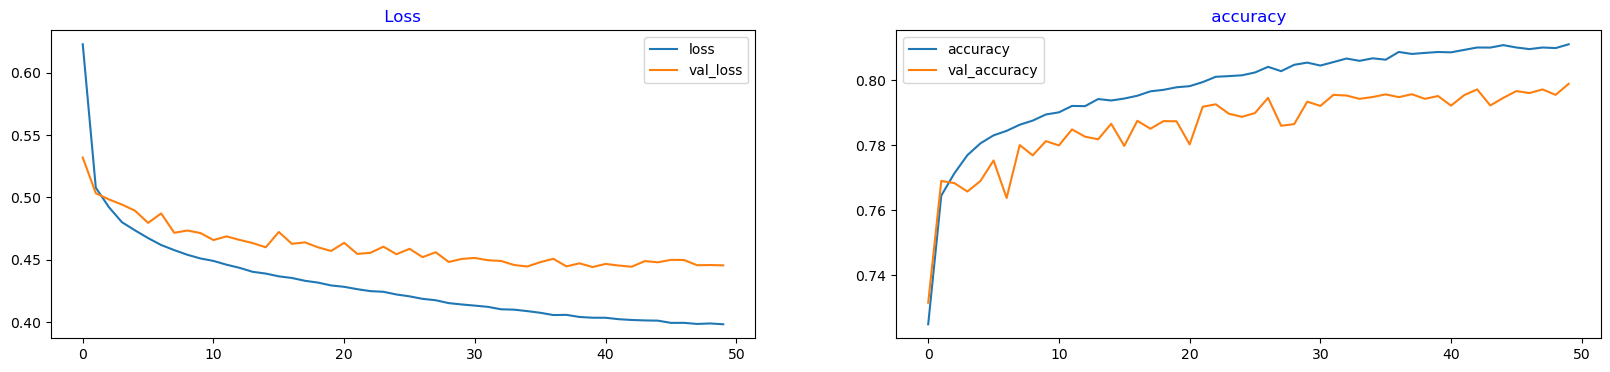

In [58]:
plt.figure(figsize=(20, 4))

plt.subplot(121)
plt.plot(df_DL['loss'], label='loss')
plt.plot(df_DL['val_loss'], label='val_loss')
plt.title(" Loss ", fontdict={"color" : "blue"})
plt.legend()

plt.subplot(122)
plt.plot(df_DL['accuracy'], label='accuracy')
plt.plot(df_DL['val_accuracy'], label='val_accuracy')
plt.title(" accuracy ", fontdict={"color" : "blue"})
plt.legend()